# Padrões de projeto com funções de primeira classe

Parte III - Funções como objetos | Capítulo 6 - Python Fluente - Luciano Ramalho

"Confirmadade aos padrões não é uma medida de qualidade" - Ralph Johnson.

## Útil

Apesar de os padrões de projeto serem independentes de linguagem, isso não quer dizer que todo padrão possa ser aplicado a todas as linguagens.

## Refatorando Strategy

O padrão "Estratégia" pode ser mais simples em Python se utilizado com funções com objetos de primeira classe.

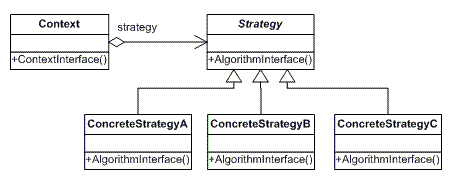

**Strategy clássico**

É definido no livro Deisgn Patterns como: "Define uma família de algoritmos, encapsula cada um e torna-os intercambiáveis. O padrão Strategy permite que o algoritmo varie independentemente dos clientes que o utilizam.

Além de "Os objetos Strategy geralmente são ótimos flyweights.", no quem tem como definição: "Um flyweight é um objeto compartilhado que pode ser usado em diversos contextos simultaneamente".

Contexto: Oferece um serviço delegando alguns cálculos para componentes intercambiáveis que implementam algoritmos alternativos.

Estratégia - Interface comum aos componentes que implementam os diferentes algoritmos.

Estratégia concreta - É uma das subclasses concretas da Estratégia.

In [1]:
from abc import ABC, abstractmethod
from collections import namedtuple

Customer = namedtuple('Customer', 'name fidelity')


class LineItem:

    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price

    def total(self):
        return self.price * self.quantity


class Order:  # the Context

    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion

    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total

    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount

    def __repr__(self):
        fmt = '<Order total: {:.2f} due: {:.2f}>'
        return fmt.format(self.total(), self.due())


class Promotion(ABC):  # the Strategy: an Abstract Base Class

    @abstractmethod
    def discount(self, order):
        """Return discount as a positive dollar amount"""


class FidelityPromo(Promotion):  # first Concrete Strategy
    """5% discount for customers with 1000 or more fidelity points"""

    def discount(self, order):
        return order.total() * .05 if order.customer.fidelity >= 1000 else 0


class BulkItemPromo(Promotion):  # second Concrete Strategy
    """10% discount for each LineItem with 20 or more units"""

    def discount(self, order):
        discount = 0
        for item in order.cart:
            if item.quantity >= 20:
                discount += item.total() * .1
        return discount


class LargeOrderPromo(Promotion):  # third Concrete Strategy
    """7% discount for orders with 10 or more distinct items"""

    def discount(self, order):
        distinct_items = {item.product for item in order.cart}
        if len(distinct_items) >= 10:
            return order.total() * .07
        return 0

In [3]:
mari = Customer('Mariana Pinheiro', 0)

In [8]:
lucas = Customer('Lucas Eduardo', 1100)

In [5]:
cart = [
    LineItem('banana', 4, .5),
    LineItem('apple', 10, 1.5),
    LineItem('watermellon', 5, 5.0)
]

In [6]:
Order(mari, cart, FidelityPromo())

<Order total: 42.00 due: 42.00>

In [9]:
Order(lucas, cart, FidelityPromo())

<Order total: 42.00 due: 39.90>

In [10]:
banana_cart = [
    LineItem('banana', 30, .5),
    LineItem('apple', 10, 1.5)
]

In [11]:
Order(mari, banana_cart, BulkItemPromo())

<Order total: 30.00 due: 28.50>

In [12]:
long_order = [
    LineItem(str(item_code), 1, 1.0)
    for item_code in range(10)
]

In [13]:
Order(mari, long_order, LargeOrderPromo())

<Order total: 10.00 due: 9.30>

In [14]:
Order(mari, cart, LargeOrderPromo())

<Order total: 42.00 due: 42.00>

### Strategy orientado a função

In [16]:
def fidelity_promo(order):
    """5% discount for customers with 1000 or more fidelity points"""
    return order.total() * .05 if order.customer.fidelity >= 1000 else 0


def bulk_item_promo(order):
    """10% discount for each LineItem with 20 or more units"""
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1
    return discount

def large_order_promo(order):
    """7% discount for orders with 10 or more distinct items"""
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * .07
    return 0

In [18]:
from abc import ABC, abstractmethod
from collections import namedtuple

Customer = namedtuple('Customer', 'name fidelity')


class LineItem:

    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price

    def total(self):
        return self.price * self.quantity


class Order:  # the Context

    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion

    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total

    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion(self)
        return self.total() - discount

    def __repr__(self):
        fmt = '<Order total: {:.2f} due: {:.2f}>'
        return fmt.format(self.total(), self.due())


In [19]:
Order(mari, cart, fidelity_promo)

<Order total: 42.00 due: 42.00>

In [21]:
Order(mari, long_order, large_order_promo)

<Order total: 10.00 due: 9.30>

### Escolhendo a melhor estratégia



In [24]:
promos = [fidelity_promo, bulk_item_promo, large_order_promo]

def best_promo(order):
    """Seleciona o melhor desconto possível."""
    return max(promo(order) for promo in promos)

In [25]:
Order(mari, long_order, best_promo)

<Order total: 10.00 due: 9.30>

In [26]:
Order(mari, cart, best_promo)

<Order total: 42.00 due: 42.00>

In [27]:
Order(lucas, cart, best_promo)

<Order total: 42.00 due: 39.90>

## Command

Outro padrão de projeto que pode ser simplificado pelo uso de funções passadas como argumentos.

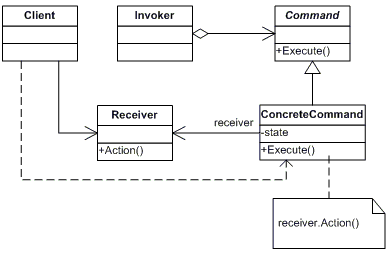

"COmmands são um substituto orientado a objetos para call-backs."